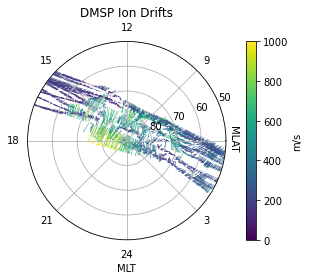

In [23]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma

import pysat
import pysatMadrigal as pysat_mad

fdate = dt.datetime(2011, 8, 15)
ivm = pysat.Instrument('dmsp', 'ivm', tag='utd', inst_id='f15')

# Define function to select northern hemisphere locations
def sel_hemisphere(inst, hemi='north'):
    """Downselect data to particular hemisphere.
    
    Parmeters
    ---------
    inst : pysat.Instrument
        DMSP Instrument object
    hemi : str
        'north' or 'south' for northern/southern hemisphere
        
    """
    
    if hemi == 'north':
        idx, = np.where(inst['mlat'] >= 0)
    elif hemi == 'south':
        idx, = np.where(inst['mlat'] <= 0)
    else:
        raise ValueError('Unrecognized input.')
        
    inst.data = inst[idx, :]
    
    return

# Select northern hemisphere data
ivm.custom_attach(sel_hemisphere, kwargs={'hemi': 'north'})

# Smooth ion drifts to only report the most robust of measurements.
ivm.custom_attach(pysat_mad.instruments.methods.dmsp.smooth_ram_drifts,
                  kwargs={'rpa_flag_key': 'rpa_flag_ut'})

# Add unit vectors relating presumed satellite orientation along
# cartesian and polar directions.
ivm.custom_attach(pysat_mad.instruments.methods.dmsp.add_drift_unit_vectors)

# Express ion drifts measured in the satellite frame along the added
# high latitude unit vectors.
ivm.custom_attach(pysat_mad.instruments.methods.dmsp.add_drifts_polar_cap_x_y,
                  kwargs={'rpa_flag_key': 'rpa_flag_ut'})

# Download data if not already on system
if fdate not in ivm.files.files.index:
    ivm.download(fdate)

# Load data and apply all custom functions
ivm.load(date=fdate)

# Plot multiple orbital passes across polar cap
f = plt.figure()
ax = f.add_subplot(111, polar=True)
ax.set_rlim(0, 40.)
ax.set_xticks(np.linspace(0, 2. * np.pi - np.pi / 4., 8))
ax.set_xticklabels(['', 9, 12, 15, 18, 21, 24, 3])
ax.set_xlabel('MLT')
ax.set_yticks([10, 20, 30, 40])
ax.set_yticklabels([80, 70, 60, 50])
ax.text(np.deg2rad(-5.), 41, 'MLAT', rotation=-90.)
ax.grid(True)

# Location of spacecraft in relative polar coords for plotting.
theta = ivm['mlt'] * (np.pi / 12.) - np.pi / 2.
r = 90. - np.abs(ivm['mlat'])

# Calculate magnitude of ion drifts for color values
mag = np.sqrt(ivm['ion_vel_pc_x']**2 + ivm['ion_vel_pc_y']**2)

# Make plot of ion drifts
slice_x = ma.masked_where(np.isnan(ivm['ion_vel_pc_x']), ivm['ion_vel_pc_x'])
slice_y = ma.masked_where(np.isnan(ivm['ion_vel_pc_y']), ivm['ion_vel_pc_y'])
vec_plot = ax.quiver(theta, r, slice_x, slice_y, mag, scale=10000,
                    clim=[0, 1000.])

# Plot drifts without both an RPA and DM measurement in red.
idx, = np.where(ivm['partial'])
ax.quiver(theta[idx], r[idx], slice_x[idx], slice_y[idx], color='r',
         scale=10000)

# Title, colorbar, and save.
plt.title('DMSP Ion Drifts')
plt.colorbar(vec_plot, label='m/s')
plt.tight_layout()
plt.savefig('ex_dmsp_methods.png')